In [15]:
import os

In [16]:
%pwd

'd:\\ML PROJECTS\\Wine-Quality-Prediction-with-MLOps\\research'

In [17]:
os.chdir('d:\\ML PROJECTS\\Wine-Quality-Prediction-with-MLOps')

In [18]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path

In [19]:
from WineQPrediction.constants import *
from WineQPrediction.utils.common import read_yaml, create_directories
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    
    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
        )

        return data_transformation_config

In [20]:
import os 
from WineQPrediction import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

class DataTransformation:
    
    def __init__(self,config: DataTransformationConfig):
        self.config = config
        
    def feature_selection(self) -> pd.DataFrame:
        data = pd.read_csv("data-cleaned.csv")
        
        print(data['quality'].unique())
        
        #if wine quality is 7 or above then we will consider it as good(1) else bad(0)
        data['quality'] = data['quality'].apply(lambda x: 1 if x >= 7 else 0)
        
        print(f"No of good vs bad vine Samples :{data['good_quality'].value_counts()}")
        
        return data
       
    
    def train_test_splitting(self):
        data1 = self.feature_selection()
        X = data1[['fixed acidity', 'volatile acidity', 'sulphates', 'alcohol', 'density']]
        y = data1.quality
        oversample = SMOTE()
        X_ros, y_ros = oversample.fit_resample(X, y)

        sns.countplot(x=y_ros)
        plt.xticks([0,1], ['bad wine','good wine'])
        plt.title("Types of Wine")
         # Specify the directory path to save the graph
        directory_path = "Visualization/images"
        file_name = "wine_quality.png"
        file_path = os.path.join(directory_path, file_name)
        # Save the graph to the specified directory
        plt.savefig(file_path)

        plt.show()
       
        df_rejoined = pd.concat([X_ros, y_ros], axis=1)
        
        data1 = self.feature_selection()
        
        train , test = train_test_split(data1)
        
        train.to_csv(os.path.join(self.config.root_dir, 'train.csv'),index=False)
        test.to_csv(os.path.join(self.config.root_dir, 'test.csv'),index=False)
        
        
        logger.info(f"Train and Test data saved at {self.config.root_dir}")
        logger.info(f"Train_data:{train.shape}")
        logger.info(f"Test_data:{test.shape}")
        
 
    
        
        
        

[2024-06-03 10:17:56,377]: INFO: common yaml file: config\config.yaml loaded successfully]
[2024-06-03 10:17:56,419]: INFO: common yaml file: params.yaml loaded successfully]
[2024-06-03 10:17:56,423]: INFO: common yaml file: Schema.yaml loaded successfully]
[2024-06-03 10:17:56,425]: INFO: common created directory at: artifacts_root]
[2024-06-03 10:17:56,426]: INFO: common created directory at: artifacts/data_transformation]


[5.  6.  7.  4.  7.5 3.5]
No of good vs bad vine Samples :good_quality
0    1382
1     217
Name: count, dtype: int64
[2024-06-03 10:17:56,866]: INFO: category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2024-06-03 10:17:56,968]: INFO: category Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


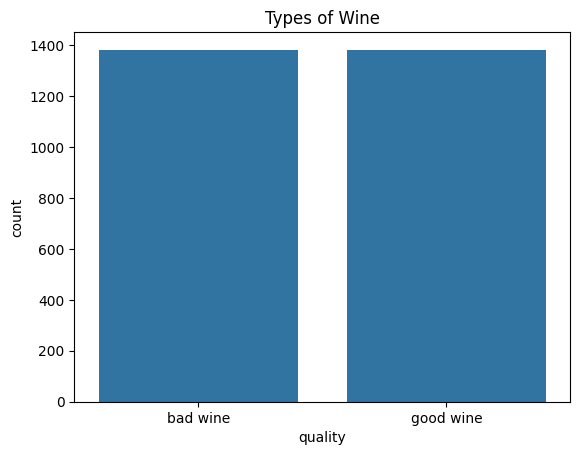

[5.  6.  7.  4.  7.5 3.5]
No of good vs bad vine Samples :good_quality
0    1382
1     217
Name: count, dtype: int64
[2024-06-03 10:17:57,716]: INFO: 2181636583 Train and Test data saved at artifacts/data_transformation]
[2024-06-03 10:17:57,717]: INFO: 2181636583 Train_data:(1199, 14)]
[2024-06-03 10:17:57,718]: INFO: 2181636583 Test_data:(400, 14)]


In [21]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.train_test_splitting()
except Exception as e:
    raise e